In [1]:
#Generate the relevant time series plots:
import string
import os
import sys
import datetime as dtte
import numpy as np
import numpy.linalg as LA
import collections
import pickle
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
DF = pd.read_csv('15TopicsTOTAL.csv')

In [3]:
start = dtte.datetime.strptime("2 Apr 07", "%d %b %y")
daterange = pd.date_range(start, periods=3209,freq='D')

In [4]:
Topic13Scores = DF['Topic 13']
Topic13Scores.index = pd.Index(daterange)

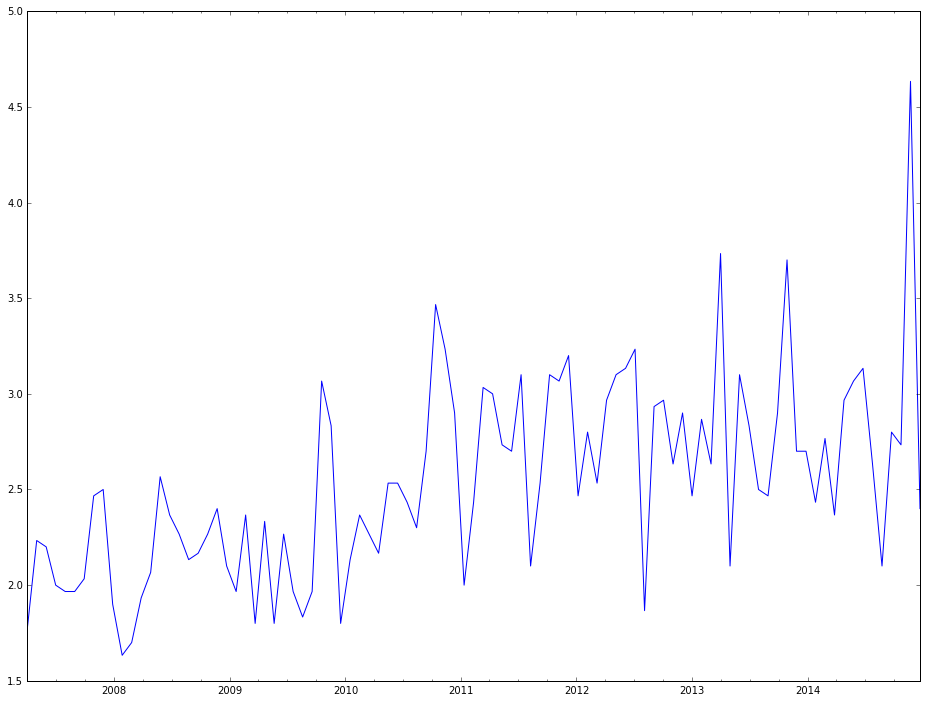

In [5]:
Topic13byMonth = Topic13Scores.resample('30D')
Topic13byMonth[:'2014-12-31'].plot(figsize=(16, 12))
ts = Topic13byMonth

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

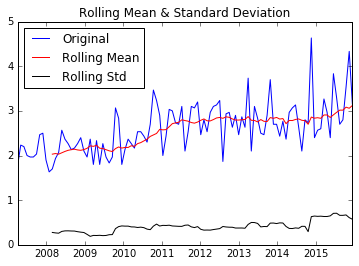

Results of Dickey-Fuller Test:
Test Statistic                 -0.668692
p-value                         0.854693
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (10%)           -2.583454
Critical Value (5%)            -2.892815
dtype: float64


In [7]:
#Apply test to our time series:
test_stationarity(Topic13byMonth)

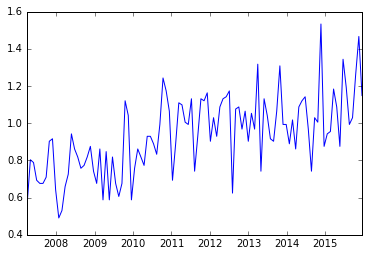

In [8]:
#Take a log transformation
ts_log = np.log(Topic13byMonth)
plt.plot(ts_log)

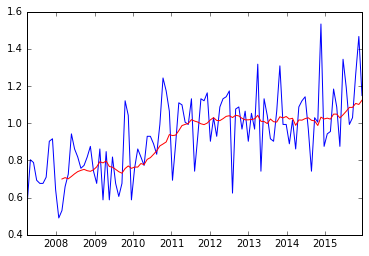

In [9]:
#Now compute the moving average
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [10]:
#difference this from the log-ed time series:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

2007-04-02         NaN
2007-05-02         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-07-31         NaN
2007-08-30         NaN
2007-09-29         NaN
2007-10-29         NaN
2007-11-28         NaN
2007-12-28         NaN
2008-01-27         NaN
2008-02-26   -0.169273
Freq: 30D, Name: Topic 13, dtype: float64

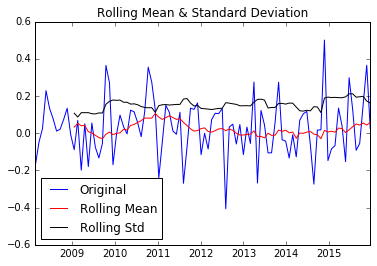

Results of Dickey-Fuller Test:
Test Statistic                 -2.330037
p-value                         0.162463
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
Critical Value (5%)            -2.896616
dtype: float64


In [11]:
#Drop the NANs and check stationarity:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [12]:
#Hmm...this is not so great...less than 90% confidence that this is actually stationary. Do I need another approach here?
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [13]:
lag_acf = acf(ts_log_moving_avg_diff, nlags=5)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=5, method='ols')

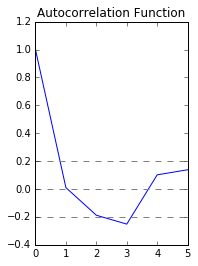

In [14]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

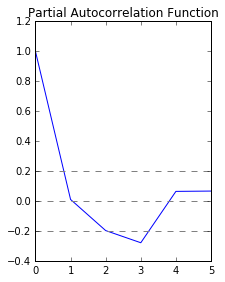

In [15]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [16]:
def objfunc(order):
    from statsmodels.tsa.arima_model import ARMA
    try:
        #fit = ARMA(DFTopic1a['First Difference'].ix['2007-04-05':], order).fit()
        fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,order).fit()
        #fit = sm.tsa.ARIMA(ts_log,order).fit()
        print(fit.aic)
        print(order)
        return fit.aic
    except:
        print('No good!')
        print(order)

from scipy.optimize import brute
grid = (slice(0,4,1), slice(0, 4, 1), slice(0,4,1))
brute(objfunc, grid, finish=None)

-85.7556440689
[0 0 0]
-85.7556440689
[0 0 0]
-83.7710882989
[0 0 1]
-85.4488782248
[0 0 2]
-89.9092735679
[0 0 3]
-19.782202272
[0 1 0]
-77.2666900317
[0 1 1]
-75.3290144022
[0 1 2]
No good!
[0 1 3]
77.0794215104
[0 2 0]
-12.0106297493
[0 2 1]
No good!
[0 2 2]
No good!
[0 2 3]
No good!
[0 3 0]
No good!
[0 3 1]
No good!
[0 3 2]
No good!
[0 3 3]
-83.7653658806
[1 0 0]
-83.8812134585
[1 0 1]
-84.6183585472
[1 0 2]
-90.9277047017
[1 0 3]
-34.5619478377
[1 1 0]
-75.3075730749
[1 1 1]
No good!
[1 1 2]
No good!
[1 1 3]
34.4259009258
[1 2 0]
No good!
[1 2 1]
No good!
[1 2 2]
nan
[1 2 3]
No good!
[1 3 0]
No good!
[1 3 1]
No good!
[1 3 2]
No good!
[1 3 3]
-85.4124434767
[2 0 0]
-86.567570851
[2 0 1]
No good!
[2 0 2]
-92.4782007543
[2 0 3]
-39.6710411896
[2 1 0]
-76.5598953403
[2 1 1]
No good!
[2 1 2]
No good!
[2 1 3]
24.3819425188
[2 2 0]
No good!
[2 2 1]
No good!
[2 2 2]
No good!
[2 2 3]
No good!
[2 3 0]
No good!
[2 3 1]
No good!
[2 3 2]
No good!
[2 3 3]
-90.6656472795
[3 0 0]
-88.8865756861
[

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[3 0 2]
-91.7089869731
[3 0 3]
-59.1877870793
[3 1 0]
-81.3356070659

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[3 1 1]
-79.3173534299
[3 1 2]
-78.9983473066
[3 1 3]
3.44212073661

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[3 2 0]
-48.7652200928
[3 2 1]
-67.7684422814
[3 2 2]
nan
[3 2 3]
No good!
[3 3 0]
No good!
[3 3 1]
No good!
[3 3 2]
No good!
[3 3 3]


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([ 0.,  1.,  3.])

In [22]:
#Double check convergence [1 0 3] [2 0 3] [3 0 0]
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(3,0,0)).fit()
fit.aic

-90.66564727952914

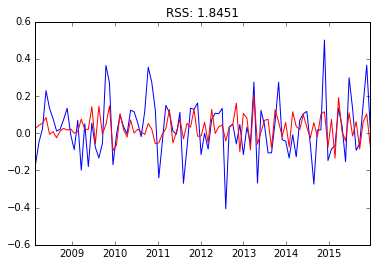

In [24]:
model = sm.tsa.ARIMA(ts_log_moving_avg_diff, order=(2, 0, 3))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
ParRSS = results_ARIMA.fittedvalues-ts_log_moving_avg_diff
ParRSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((ParRSS)**2))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/tsa/arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


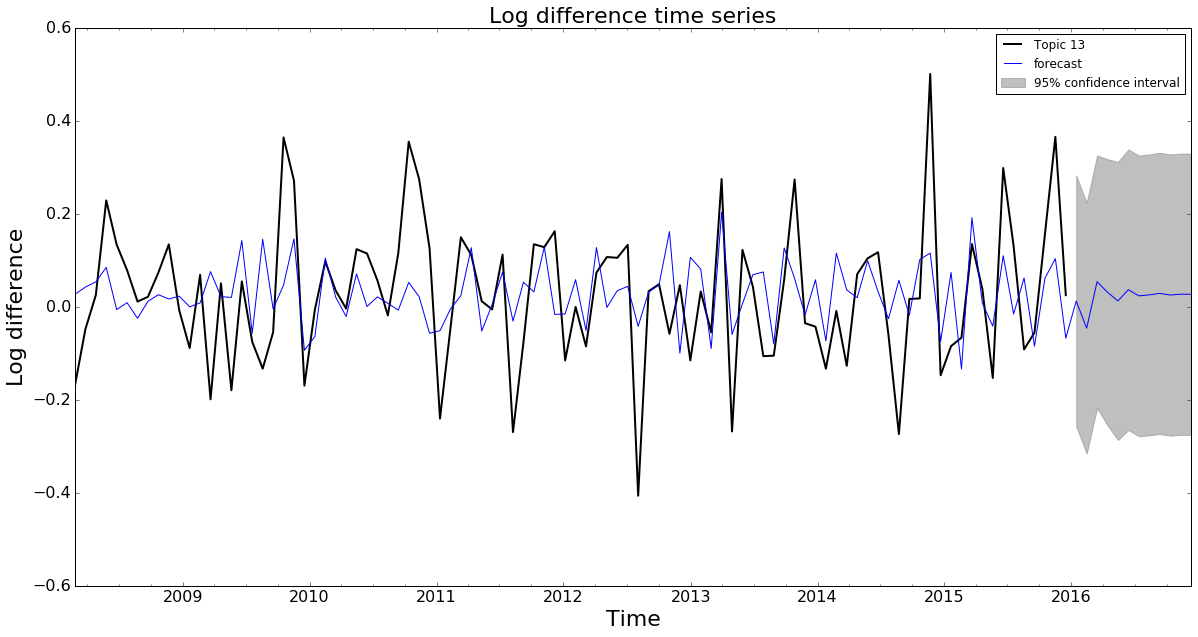

In [25]:
#Well not a great fit, but it's honest at least...can we transform back to original data and make predictions?
#Make predictions first to make sure it looks ok... 2007-05-02 2013-12-26 (2,0,1)
with mpl.rc_context():
    mpl.rc('axes', color_cycle=['#0000FF', '#FF6600'])
    fig, ax = plt.subplots(figsize=(20, 10))
    ax = ts_log_moving_avg_diff.plot(linewidth=2.0,ax=ax,color='black')
    fig = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,3)).fit(disp=-1).plot_predict('2008-02-26', '2016', ax=ax,plot_insample=False)
    plt.xticks(fontsize=16)  
    plt.yticks(fontsize=16)
    plt.title("Log difference time series",fontsize=22)
    plt.xlabel("Time",fontsize=22)
    plt.ylabel("Log difference",fontsize=22)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


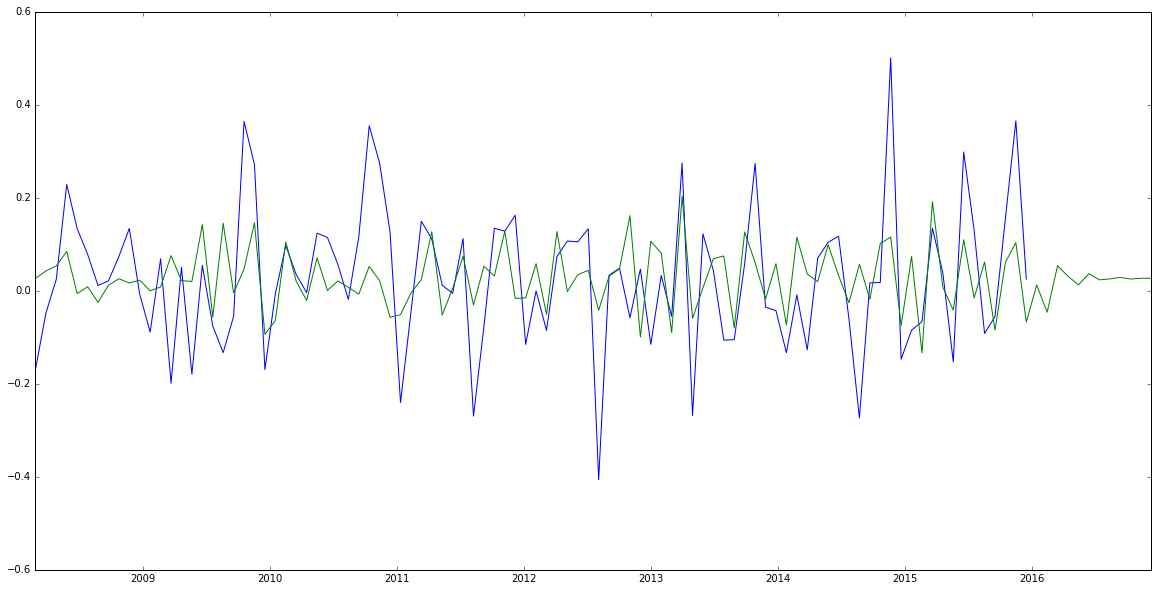

In [26]:
plt.subplots(figsize=(20, 10))
plt.plot(ts_log_moving_avg_diff)
plt.plot(sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,3)).fit(disp=-1).predict('2008-02-26', '2016'))

2008-02-26    0.026710
2008-03-27    0.042524
2008-04-26    0.053516
2008-05-26    0.084709
2008-06-25   -0.005904
Freq: 30D, dtype: float64


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


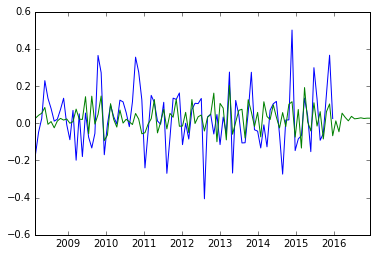

In [12]:
predictions_ARIMA_diff = pd.Series(sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,3)).fit(disp=-1).predict('2008-02-26', '2016'), copy=True)
print(predictions_ARIMA_diff.head())
plt.plot(ts_log_moving_avg_diff)
plt.plot(predictions_ARIMA_diff)

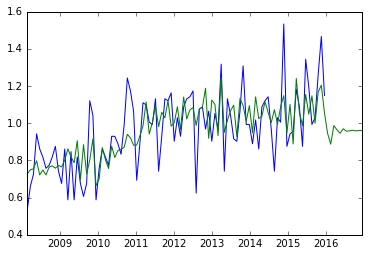

In [13]:
SplitPredict = predictions_ARIMA_diff['2016-01-15':]
InRangePredict = predictions_ARIMA_diff[:'2015-12-16']
InRangeTrans = InRangePredict + moving_avg
MovingToAdd = moving_avg.mean()
AverageDF = pd.Series([MovingToAdd for x in range(len(SplitPredict.index))], index=SplitPredict.index)
PredictedNew = SplitPredict + AverageDF
FullPredict = pd.Series.append(InRangeTrans,PredictedNew)
compare = ts_log_moving_avg_diff + moving_avg
plt.plot(compare)
plt.plot(FullPredict)

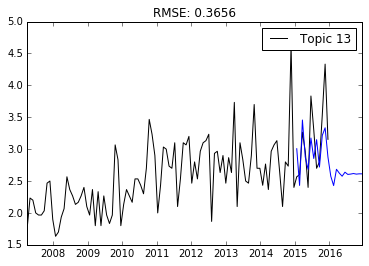

In [14]:
predictions_ARIMA = np.exp(FullPredict)
plt.plot(ts,color='black')
plt.plot(predictions_ARIMA['2015-01-20':],color='blue')
RMSEeval = predictions_ARIMA-ts
RMSEeval.dropna(inplace=True)
plt.title('RMSE: %.4f'% np.sqrt(sum((RMSEeval)**2)/len(ts)))
plt.legend()

In [15]:
TestConf = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,3)).fit(disp=-1)
lowerInts = []
upperInts = []
for nums in TestConf.forecast(12)[2]:
    lowerInts.append(nums[0])
    upperInts.append(nums[1])

In [16]:
lowerIntPD_orig = pd.Series(lowerInts,index=SplitPredict.index)
upperIntPD_orig = pd.Series(upperInts,index=SplitPredict.index)

In [17]:
lowerIntPD_avg = lowerIntPD_orig + AverageDF
upperIntPD_avg = upperIntPD_orig + AverageDF

In [18]:
FullLowerInt = np.exp(lowerIntPD_avg)
FullUpperInt = np.exp(upperIntPD_avg)

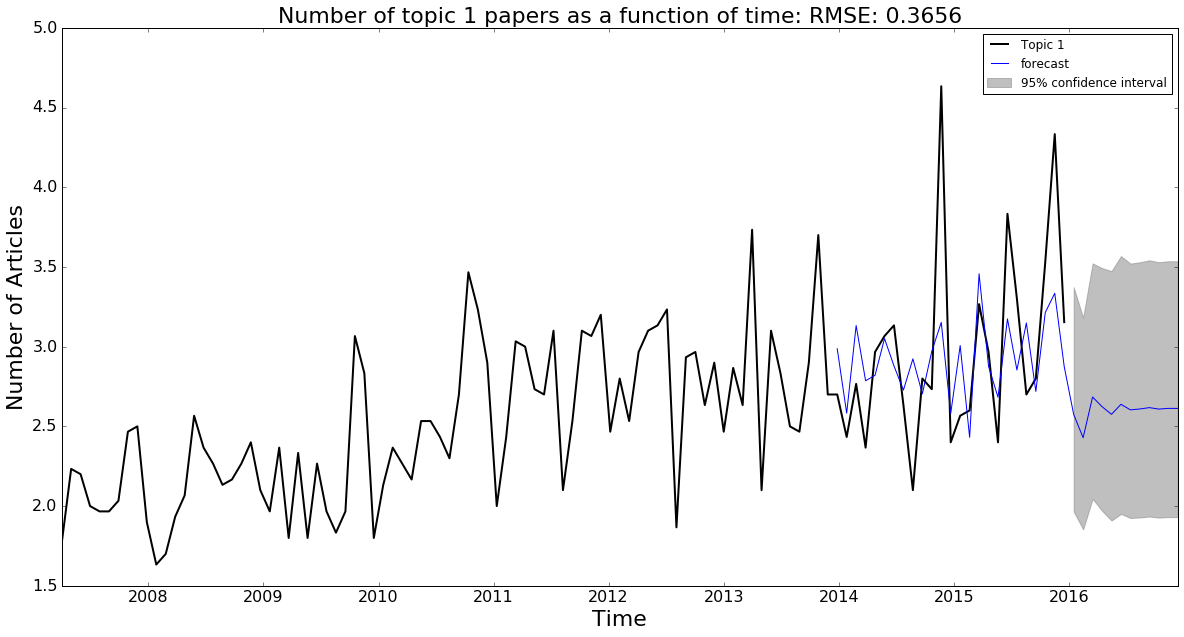

In [19]:
fig,ax= plt.subplots(figsize=(20, 10))
fig = plt.plot(ts,linewidth=2.0,color='black')
ax = plt.plot(predictions_ARIMA['2013-12-26':],color='blue')
plt.fill_between(FullLowerInt.index,FullLowerInt.values,FullUpperInt.values,color='grey',alpha=0.5)
RMSEeval = predictions_ARIMA-ts
RMSEeval.dropna(inplace=True)
plt.title('Number of topic 1 papers as a function of time: RMSE: %.4f'% np.sqrt(sum((RMSEeval)**2)/len(ts)),fontsize=22)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)
#plt.title("Number of papers as a function of time",fontsize=22)
plt.xlabel("Time",fontsize=22)
plt.ylabel("Number of Articles",fontsize=22)
plt.legend(['Topic 1','forecast','95% confidence interval'],loc='best')